# RNN Based Models
Bidirectional is better

The output of the Bidirectional RNN will be, by default, the concatenation of the forward layer output and the backward layer output.

In [1]:
import os
import pathlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
from models import *
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from python_speech_features import mfcc
import librosa.display
import librosa as lr
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from hyperparams import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from metrics import *
from custom_layers import MFCC, LogMelSpectrogram, Spectrogram
from utils import *

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2021-08-23 17:21:46.041758: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# _SMOKE_SIZE_ = 10000
_SMOKE_SIZE_ = -1

In [3]:
current_task = _TASKS_[1]
print(current_task)
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task, smoke_size=_SMOKE_SIZE_)



print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

35kws
Core keywords:  ['off' 'three' 'happy' 'eight' 'up' 'no' 'seven' 'marvin' 'five' 'cat'
 'visual' 'forward' 'right' 'wow' 'zero' 'learn' 'bird' 'left' 'nine'
 'house' 'dog' 'backward' 'on' 'two' 'sheila' 'follow' 'tree' 'yes' 'four'
 'one' 'stop' 'six' 'down' 'go' 'bed']

Auxiliary keywords:  []

Output Classes:  ['off' 'three' 'happy' 'eight' 'up' 'no' 'seven' 'marvin' 'five' 'cat'
 'visual' 'forward' 'right' 'wow' 'zero' 'learn' 'bird' 'left' 'nine'
 'house' 'dog' 'backward' 'on' 'two' 'sheila' 'follow' 'tree' 'yes' 'four'
 'one' 'stop' 'six' 'down' 'go' 'bed']
Samples in Training Set: 94824
Samples in Test Set: 9981
Samples in Validation Set: 11005


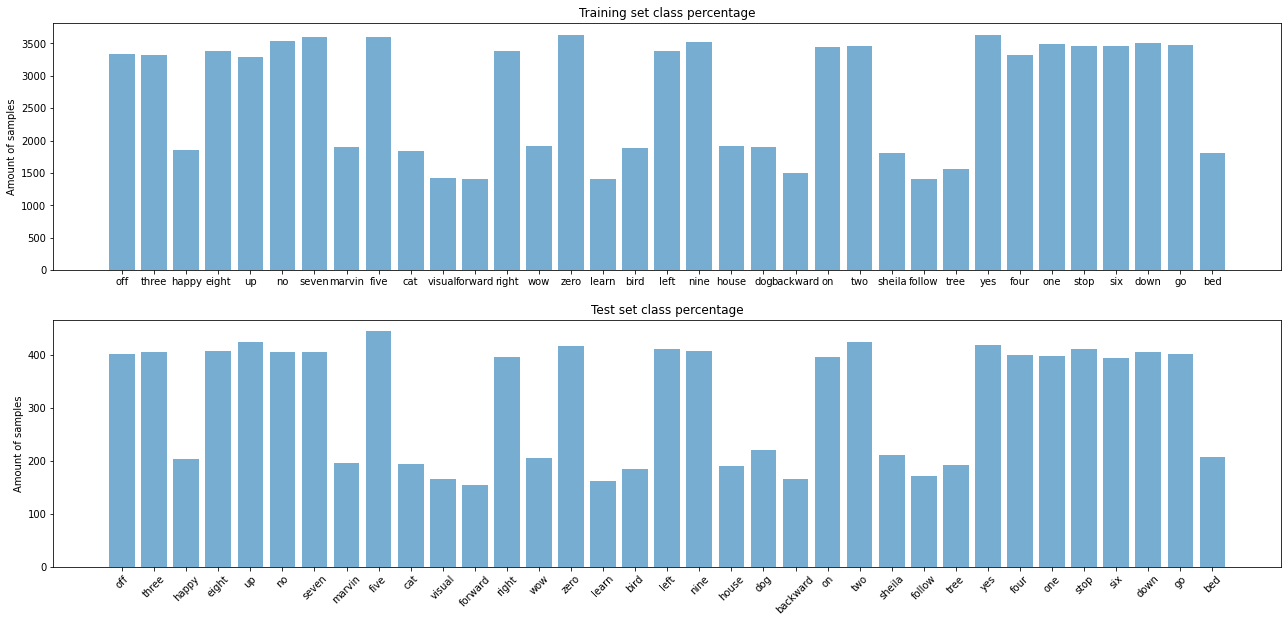

In [4]:
visualize_class_balance(y_train,y_valid,output_classes)

In [5]:
batch_size = 128
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset, test_steps = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size,
                            task=current_task)

# get dataset with noise waves
# noises_ds = get_noises_tf_dataset()

2021-08-23 17:21:48.105655: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-23 17:21:48.117892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 17:21:48.118211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-23 17:21:48.118246: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-23 17:21:48.120821: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-23 17:21:48.120922: I tensorflow/stream_executor/platf

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Train steps: 741
Validations steps: 86
Test steps: 78
Example of dataset element:
(<tf.Tensor: shape=(128, 16000), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -4.1207345e-04,  9.4595547e-05,  2.2806585e-04],
       [-4.4349083e-04,  7.9640961e-04,  3.6353755e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.5690483e-02,  7.2689250e-02,  8.7434642e-02],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.2545367e-01,  4.1334146e-01,  4.3170622e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -7.3718996e-04, -5.2382732e-03, -2.9688000e-03],
       [-1.2035919e-02, -8.9747626e-03, -1.2766424e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtyp

2021-08-23 17:21:49.534038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-23 17:21:49.552923: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2021-08-23 17:21:49.649362: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
epochs = 5
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

## Manually Check dataset

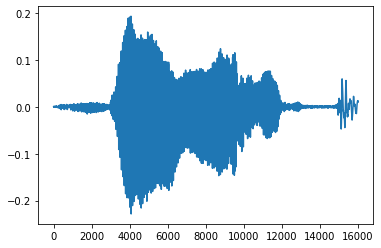

In [7]:
plt.plot(decode_audio(X_train[1]))

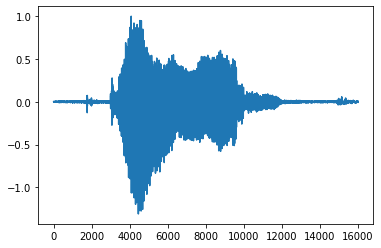

In [8]:
plt.plot(generate_sample(X_train[1]))

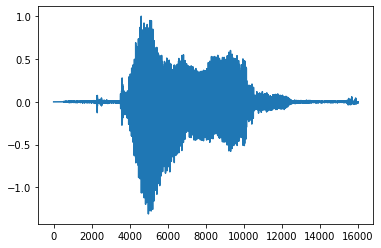

In [9]:
plt.plot(augment_sample(generate_sample(X_train[1])))

In [10]:
aug = RandomNoiseAugment()

In [11]:
for i in train_dataset.take(1):
    b = i[0]
b = b[:10]
b
b2 = aug(b, training=True)

2021-08-23 17:21:52.461178: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
b

<tf.Tensor: shape=(10, 16000), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -4.1207345e-04,  9.4595547e-05,  2.2806585e-04],
       [-4.4349083e-04,  7.9640961e-04,  3.6353755e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.5690483e-02,  7.2689250e-02,  8.7434642e-02],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.9051738e-04, -2.0917252e-04, -7.0450464e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.6726643e-03,  9.0207718e-03, -3.7283599e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.1618303e-05, -6.7101128e-04,  3.6185424e-04]], dtype=float32)>

In [13]:
b2

<tf.Tensor: shape=(10, 16000), dtype=float32, numpy=
array([[-4.2524268e-03, -3.3017225e-03, -7.7394848e-03, ...,
         1.3014475e-02, -5.3691893e-04, -3.3173391e-03],
       [-1.8069440e-02, -3.3602502e-02,  4.2566396e-02, ...,
        -3.7244655e-02,  3.3972422e-03,  1.3701718e-02],
       [-1.1140835e-02, -4.0797174e-02, -5.9032408e-03, ...,
        -9.1311540e-03,  5.6661163e-02,  8.5209981e-02],
       ...,
       [-1.1140835e-02, -4.0797174e-02, -5.9032408e-03, ...,
        -2.4531120e-02, -1.6237261e-02, -2.2951136e-03],
       [-2.0221679e-03, -9.5838500e-04, -5.0738029e-04, ...,
        -1.2406635e-02, -5.8035571e-03, -3.5861954e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.1618303e-05, -6.7101128e-04,  3.6185424e-04]], dtype=float32)>

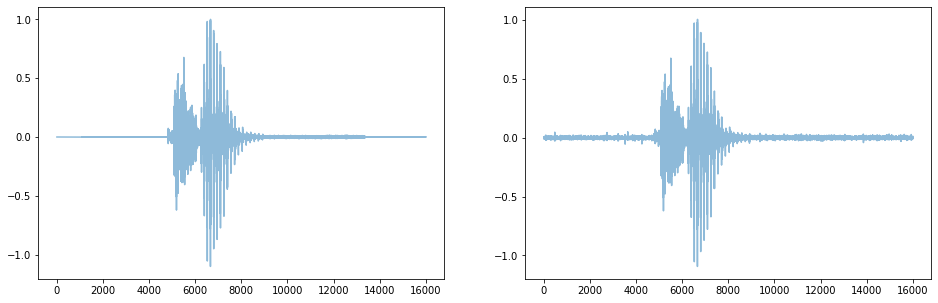

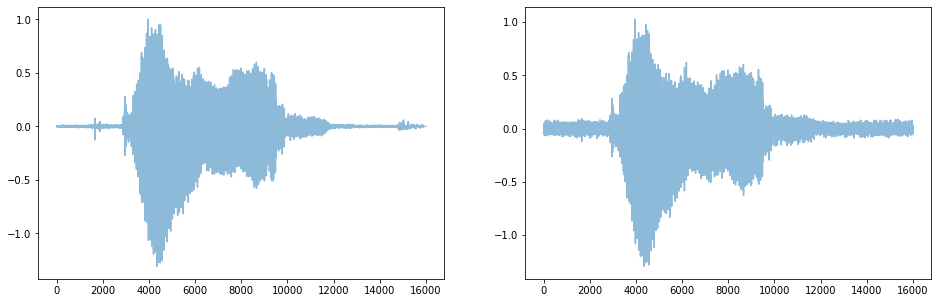

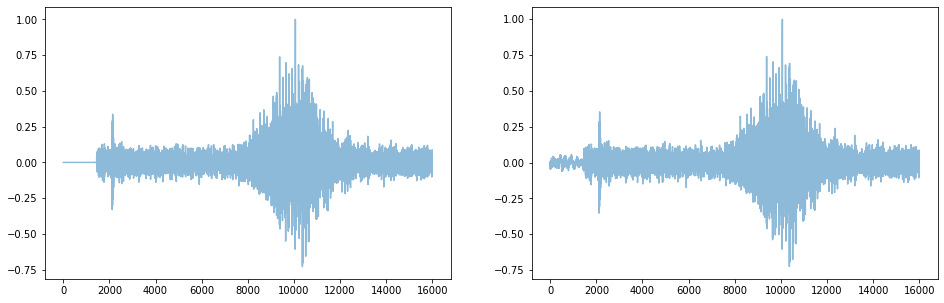

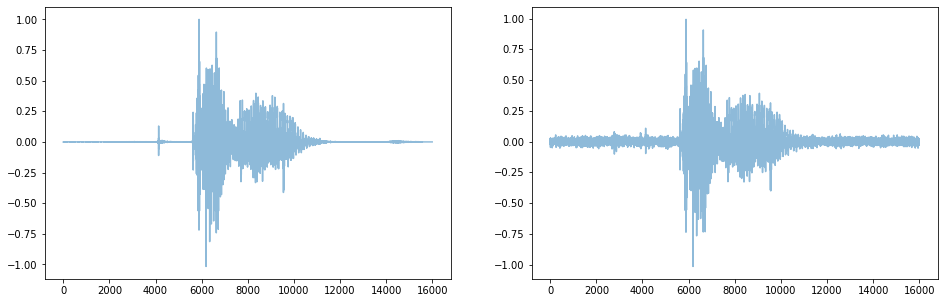

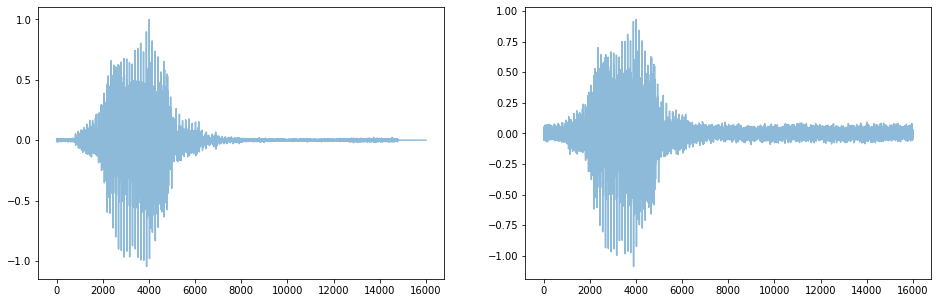

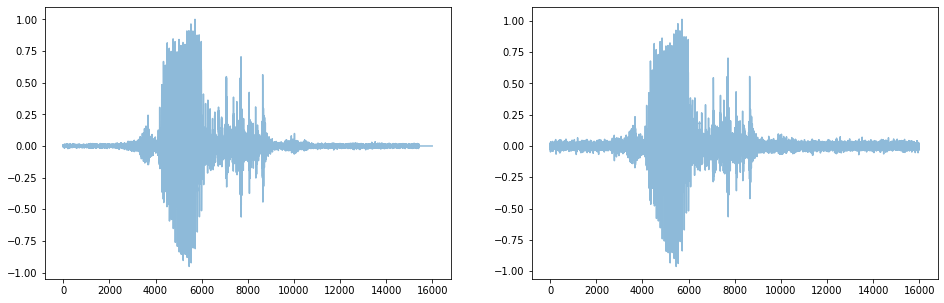

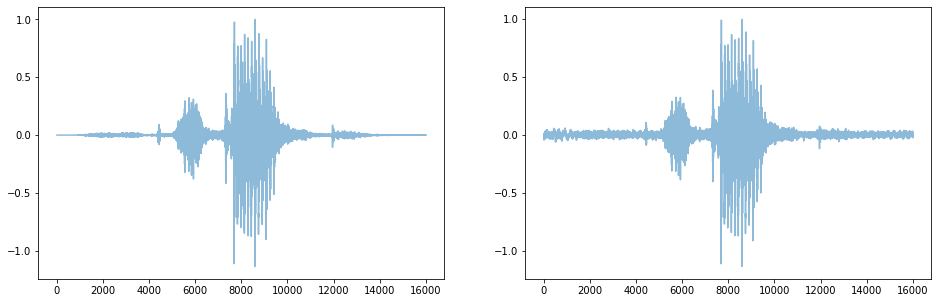

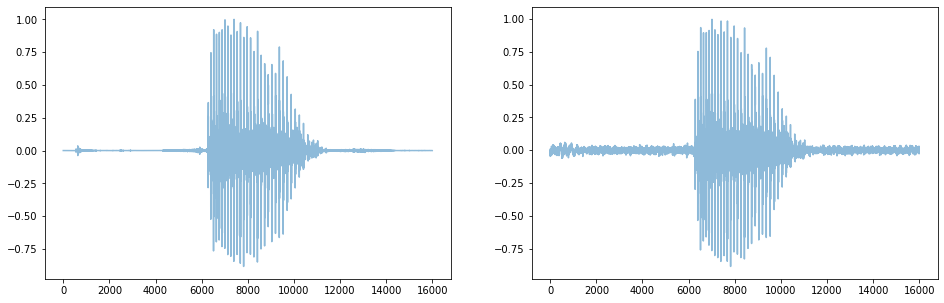

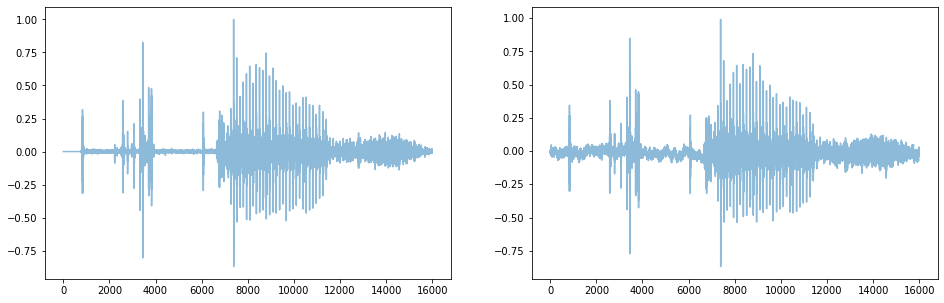

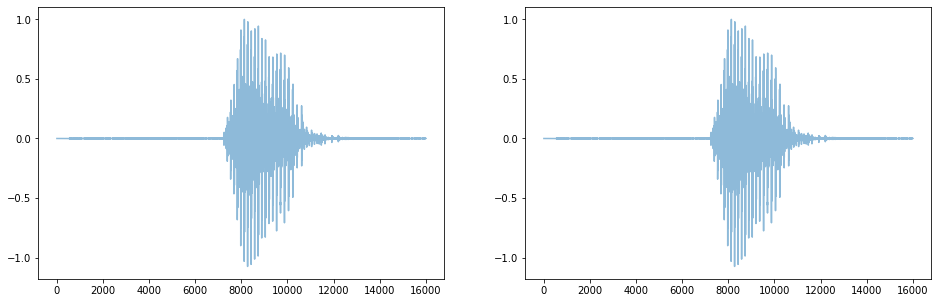

In [14]:
for i in range(10):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(b[i], alpha=0.5)
    plt.subplot(1,2,2)
    plt.plot(b2[i], alpha=0.5)
    plt.show()

In [45]:
## Randomly translate the batch of noises?? can it be useful?

n = generate_noise_crop()
n = tf.expand_dims(n,0)
for i in range(3):
    n2 = generate_noise_crop()
    n2 = tf.expand_dims(n2,0)
    n = tf.concat([n,n2], axis=0)
#     nss.append(n)
    
n2 = tf.expand_dims(n,1)
n2 = tf.expand_dims(n2,-1)
n2.shape
shifted = layers.experimental.preprocessing.RandomTranslation(height_factor=0., width_factor=0.1, fill_mode='reflect')(n2)
shifted = shifted[:,0,:,0]
shifted

<tf.Tensor: shape=(4, 16000), dtype=float32, numpy=
array([[ 0.03051915,  0.01970974,  0.00771386, ..., -0.04244313,
        -0.03368855, -0.03472921],
       [ 0.0044669 ,  0.16834809, -0.25478634, ...,  0.12509628,
         0.17755826, -0.04697652],
       [ 0.15651044, -0.02396153, -0.08867916, ..., -0.3214171 ,
        -0.1329484 ,  0.11494211],
       [ 0.03764073,  0.05697382,  0.03760923, ...,  0.00849862,
         0.01182197,  0.0252874 ]], dtype=float32)>

## Simple RNN

In [18]:
model_simple_rnn = simple_rnn(train_dataset, output_classes, "try")
model_simple_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


In [19]:
model_simple_rnn.summary()

Model: "simple_rnn_try"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc_1 (MFCC)                (None, 98, 40, 1)         0         
_________________________________________________________________
spec_augment (SpecAugment)   (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 98, 40, 1)         4         
_________________________________________________________________
lambda (Lambda)              (None, 98, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               130560    
_________________________________________________________________
dense_4 (Dense)              (None, 12)             

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
            verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_simple_rnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)


Epoch 1/5
16/16 [==============================] - 4s 98ms/step - loss: 1.9202 - accuracy: 0.4971 - val_loss: 2.2383 - val_accuracy: 0.5547
Epoch 2/5
16/16 [==============================] - 1s 36ms/step - loss: 1.6429 - accuracy: 0.6113 - val_loss: 1.8054 - val_accuracy: 0.5625
Epoch 3/5
16/16 [==============================] - 1s 38ms/step - loss: 1.5077 - accuracy: 0.6504 - val_loss: 1.8973 - val_accuracy: 0.5547
Epoch 4/5
16/16 [==============================] - 1s 36ms/step - loss: 1.5555 - accuracy: 0.6367 - val_loss: 1.7968 - val_accuracy: 0.5703
Epoch 5/5
16/16 [==============================] - 1s 39ms/step - loss: 1.5144 - accuracy: 0.6475 - val_loss: 1.8274 - val_accuracy: 0.5625


In [21]:
#save model
# model_simple_rnn.save(_MODELS_DIR_/current_task/(model_simple_rnn.name+'.h5'))
model_simple_rnn.save("test_simple.h5")

In [ ]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

In [ ]:
y_scores = model_simple_rnn.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

In [ ]:
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {model_simple_rnn.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

## CNN + RNN

In [ ]:
def cnn_rnn(ds, 
               output_classes, 
               n_mfcc, 
               mfcc_deltas, 
               fft_size=512, 
               win_size=400, 
               hop_size=160, 
               n_filters=40):
    
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X = MFCC(sample_rate = 16000, 
             fft_size=fft_size, 
             win_size=win_size, 
             hop_size=hop_size, 
             n_filters=n_filters, 
             n_cepstral=n_mfcc,
            return_deltas=mfcc_deltas)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Conv2D(64, (20,1))(X)
    X = layers.BatchNormalization(axis =-1)(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(1, (10,1))(X)
    X = layers.BatchNormalization(axis =-1)(X)
    X = layers.Activation('relu')(X)

    
    X = layers.Lambda(lambda w: tf.keras.backend.squeeze(w, -1))(X)
    X = layers.Bidirectional(layers.GRU(units=128))(X)
    X = layers.Dense(len(output_classes))(X)

    model = tf.keras.Model(inputs=X_input, outputs=X, name="SimpleRNN")
    return model

In [ ]:
model_cnn_rnn = cnn_rnn(train_dataset, output_classes, n_mfcc=40, mfcc_deltas=False)
model_cnn_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_rnn.summary()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
            verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_rnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)


## Attention based RNN

In [10]:
att_model = simple_attention_rnn(train_dataset, output_classes, mfccs=True, model_suffix="mfccs")
att_model.summary()

Input shape: (16000,)
Model: "simple_attention_rnn_mfccs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
mfcc (MFCC)                     (None, 98, 40, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
spec_augment (SpecAugment)      (None, 98, 40, 1)    0           mfcc[0][0]                       
__________________________________________________________________________________________________
squeeze_channel_dimension (Lamb (None, 98, 40)       0           spec_augment[0][0]               
___________________________________________________

In [11]:
# tf.keras.utils.plot_model(att_model)

In [12]:
att_model.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history = att_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/7


2021-08-23 02:07:02.223539: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 4857397248 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2021-08-23 02:07:02.750381: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-23 02:07:02.845734: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-23 02:07:03.15918

 1/79 [..............................] - ETA: 5:44 - loss: 2.5475 - out_layer_loss: 2.5475 - out_layer_accuracy: 0.0156

2021-08-23 02:07:03.637986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


23/79 [=======>......................] - ETA: 18s - loss: 1.8061 - out_layer_loss: 1.8061 - out_layer_accuracy: 0.5537

KeyboardInterrupt: 

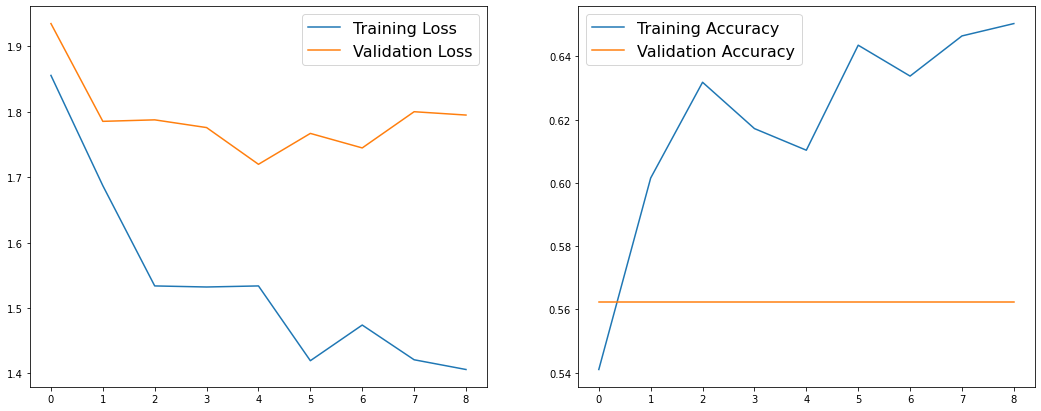

In [25]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_out_layer_loss'])), training_data['val_out_layer_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['out_layer_accuracy'])), training_data['out_layer_accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_out_layer_accuracy'])), training_data['val_out_layer_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

In [26]:
y_scores = att_model.predict(test_dataset)[0]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 50.000%


In [ ]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = att_model(ex)[1]
    plt.plot(np.log(atts[0,0,:] + 0.000001))
    
    plt.show()

## Attention model from paper

In [7]:
model_att_andreade = attention_rnn_andreade(train_dataset, output_classes, "test_train", mfccs=True)
model_att_andreade.summary()

Input shape: (16000,)
Model: "andreade_original_test_train"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
random_noise_augment (RandomNoi (None, 16000)        0           input_1[0][0]                    
__________________________________________________________________________________________________
mfcc (MFCC)                     (None, 98, 40, 1)    0           random_noise_augment[0][0]       
__________________________________________________________________________________________________
spec_augment (SpecAugment)      (None, 98, 40, 1)    0           mfcc[0][0]                       
_________________________________________________

In [8]:
model_att_andreade.compile(
    optimizer=optimizer,
    loss={'out_layer':loss},
    metrics={'out_layer':'accuracy'},
)

history = model_att_andreade.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/5


2021-08-23 17:10:21.218493: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 4932435968 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2021-08-23 17:10:21.615643: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-23 17:10:21.689501: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-23 17:10:21.93725

 78/741 [==>...........................] - ETA: 50s - loss: 3.3089 - out_layer_loss: 3.3089 - out_layer_accuracy: 0.1035

KeyboardInterrupt: 

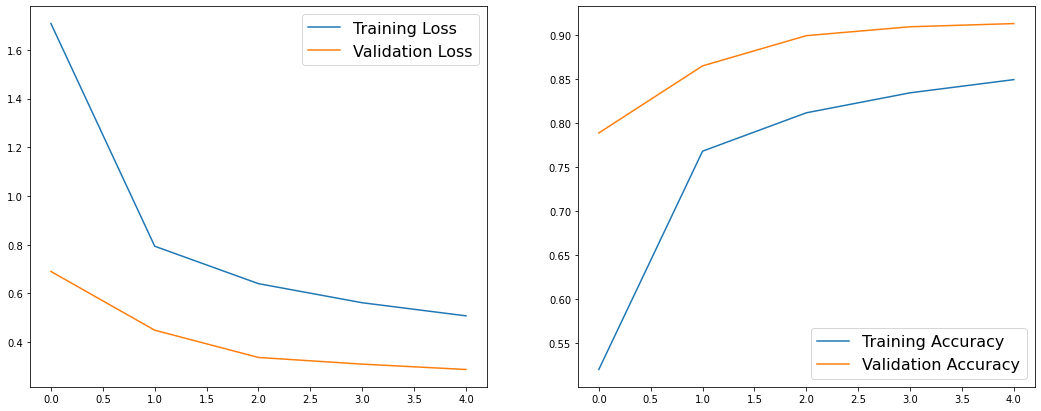

In [11]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_out_layer_loss'])), training_data['val_out_layer_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['out_layer_accuracy'])), training_data['out_layer_accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_out_layer_accuracy'])), training_data['val_out_layer_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

In [12]:
y_scores = model_att_andreade.predict(test_dataset.batch(batch_size))[0]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

2021-08-23 16:47:42.877130: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5101780992 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [13]:
# compute test accuracy
test_acc = sum(np.equal(y_pred, y_true)) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 94.109%


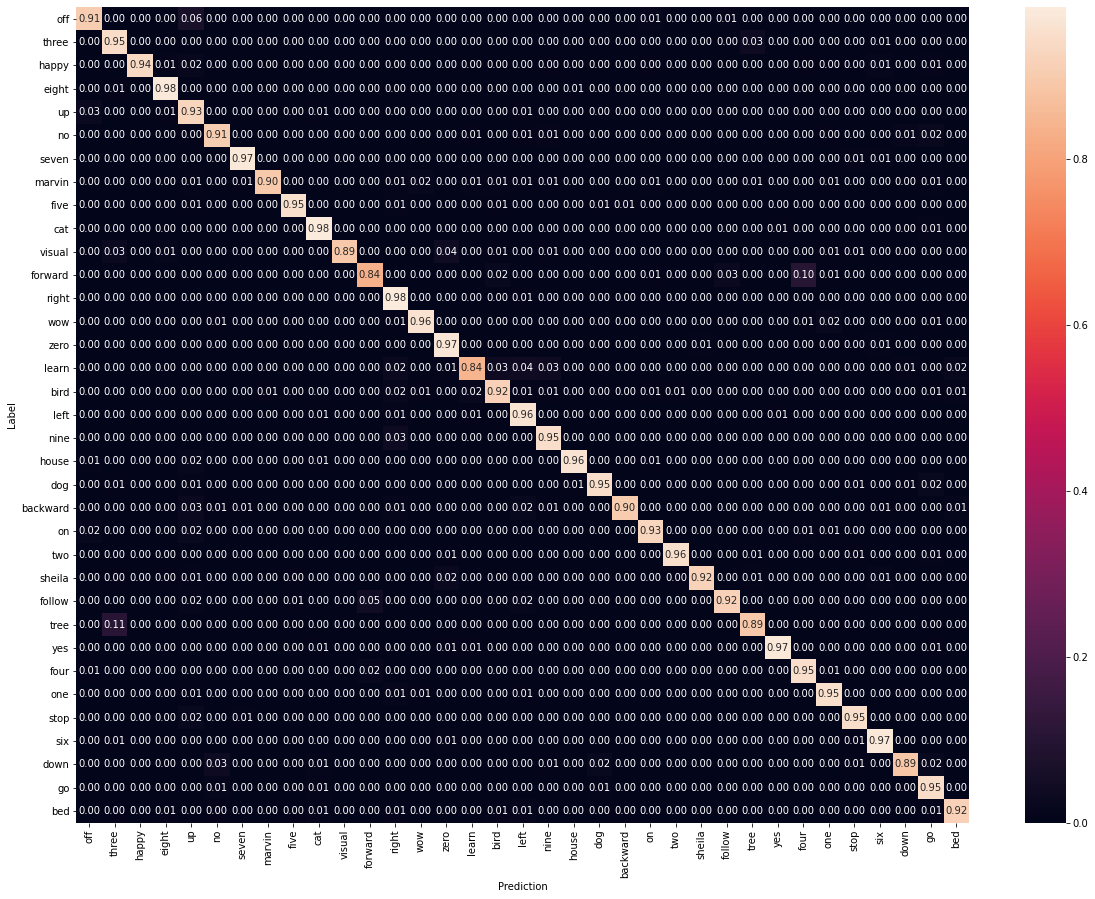

In [15]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 15))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
# plt.title(f"Model: {model.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model.name}.png', dpi=300)
plt.show()

In [ ]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = model_att_andreade(ex)[1]
    plt.plot(np.log(atts[0,0,:] + 0.000001))
    
    plt.show()

In [33]:
current_task

'10kws+U+S'

In [44]:
# model_att_andreade.save(hyperparams._MODELS_DIR_/current_task/f'{model_att_andreade.name}_{test_acc}.h5')
model_att_andreade.save(hyperparams._MODELS_DIR_/current_task/model_att_andreade.name)

INFO:tensorflow:Assets written to: models/10kws+U+S/andreade_original_test_train/assets


INFO:tensorflow:Assets written to: models/10kws+U+S/andreade_original_test_train/assets


In [45]:
# test = tf.keras.models.load_model(f'models/{current_task}/andreade_original_test_train')

## Attention from paper but with whole sequence as query

In [ ]:
model_andreade_queries = attention_rnn_andreade_seq_query(train_dataset, output_classes, "andreade_test_mod")
model_andreade_queries.summary()

In [ ]:
model_andreade_queries.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

history = model_andreade_queries.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

y_scores = model_andreade_queries.predict(test_dataset)[0]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

In [ ]:
att_scores = model_andreade_queries.predict(test_dataset)[1]

In [ ]:
ex_att = att_scores[0]
ex_att = tf.constant(ex_att)
ex_att = tf.reduce_mean(ex_att, axis=0)

In [ ]:
plt.plot(ex_att)

In [ ]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = model_andreade_queries(ex)[1][0]
    atts = tf.reduce_mean(atts, axis=0)
#     print(atts)
#     
    plt.plot(np.log(atts + 0.000001))
    
    plt.show()

## Attention with Multi Head Attention module from Transformers

In [6]:
## Define common training objects
epochs = 5
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

In [7]:
feature_types = ['mfccs', 'log_mel']
ft_type = feature_types[0]

In [39]:
for ft_type in feature_types:

    f_widths=[5]
    f_heights=[1]
    for fw,fh in list(itertools.product(f_widths, f_heights)):
        print("Current filter dimension:",(fw,fh))
        #grid search on number of heads for MHA
        for n_heads in [7]:
            andreade_mha = mha_andreade(
                train_dataset,
                output_classes,
                model_suffix=f"{ft_type}_{current_task[:2]}_{fw}{fh}_filter",
                mfccs=True if ft_type=='mfccs' else False,
                n_heads=n_heads,
                filter_w = fw,
                filter_h = fh)

            andreade_mha.compile(
                optimizer=optimizer,
                loss={'out_layer':loss},
                metrics={'out_layer':'accuracy'})

            history = andreade_mha.fit(
                train_dataset,
                validation_data=valid_dataset,
                epochs=5,
                callbacks=[early_stopping, reduce_lr],
                steps_per_epoch=train_steps,
                validation_steps=valid_steps)
            
            y_scores = andreade_mha.predict(test_dataset)[0]
            y_pred = np.array(np.argmax(y_scores, axis=1))
            y_true = np.array(y_test)

            # compute test accuracy
            test_acc = sum(y_pred == y_true) / len(y_true)
            print(f'Test set accuracy: {test_acc:.3%}')

Current filter dimension: (5, 1)
Input shape: (16000,)
Epoch 1/5
16/16 [==============================] - 10s 165ms/step - loss: 1.8075 - out_layer_loss: 1.8075 - out_layer_accuracy: 0.5771 - val_loss: 1.7950 - val_out_layer_loss: 1.7950 - val_out_layer_accuracy: 0.5625
Epoch 2/5
16/16 [==============================] - 1s 53ms/step - loss: 1.6656 - out_layer_loss: 1.6656 - out_layer_accuracy: 0.6016 - val_loss: 1.7811 - val_out_layer_loss: 1.7811 - val_out_layer_accuracy: 0.5625
Epoch 3/5
16/16 [==============================] - 1s 51ms/step - loss: 1.5554 - out_layer_loss: 1.5554 - out_layer_accuracy: 0.6318 - val_loss: 1.7753 - val_out_layer_loss: 1.7753 - val_out_layer_accuracy: 0.5625
Epoch 4/5
16/16 [==============================] - 1s 53ms/step - loss: 1.5969 - out_layer_loss: 1.5969 - out_layer_accuracy: 0.6172 - val_loss: 1.7526 - val_out_layer_loss: 1.7526 - val_out_layer_accuracy: 0.5625
Epoch 5/5
16/16 [==============================] - 1s 52ms/step - loss: 1.6117 - out_la

In [42]:
# tf.keras.models.save_model(andreade_mha,"./test", save_format='h5', overwrite=True, save_traces=False)
andreade_mha.save_weights(hyperparams._MODELS_DIR_/current_task/andreade_mha.name/f"{andreade_mha.name}_weights")
# andreade_mha.save_weights("models/10kws+U+S/PrOVAA")

In [37]:
andreade_mha.name

'mha_andreade_log_mel_10_5/1_filter'

In [30]:
andreade_mha.load_weights(")

In [17]:
andreade_mha.summary()

Model: "mha_andreade_log_mel_10_5/1_filter"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16000)]      0                                            
__________________________________________________________________________________________________
log_mel_spectrogram (LogMelSpec (None, 98, 81, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
remove_energies (Lambda)        (None, 98, 80, 1)    0           log_mel_spectrogram[0][0]        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 98, 80, 10)   60          remove_energies[0][0]            
_________________________________________________________________

In [ ]:
mod_mha.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_out_layer_accuracy', verbose=1)
history =mod_mha.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

In [ ]:
y_scores = mod_mha.predict(test_dataset)
y_scores = y_scores[0][:,0,:]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

In [ ]:
mod_mha.save(_MODELS_DIR_/current_task/("andreade_MHA"+'.h5'))

In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {mod_mha.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

In [ ]:
ex = generate_test_sample(X_test[21])
ex = tf.expand_dims(ex,0)
atts = mod_mha(ex)[1]

In [ ]:
atts = tf.reshape(atts, (7,98))

In [ ]:
plt.plot(ex[0])

In [ ]:
log_att_tot = np.log(atts + 0.00001)

plt.plot(tf.reduce_mean(log_att_tot, axis=0))

Here the model computes a number equal to `num_heads` vectors of attention weights. If avaraged together, they give an idea of where the attention is concentrated.

## Keyword Transformer

In [ ]:
kwt = KWT(train_dataset, 
                 num_patches=98,
                 num_layers=2,
                 d_model=192,
                 num_heads=3,
                 mlp_dim=768,
                 output_classes=output_classes)

In [ ]:
kwt.summary()

In [ ]:
# tf.keras.utils.plot_model(test_model)

In [ ]:
kwt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_accuracy', verbose=1)
history =kwt.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)